Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Object Detection with ONNX Runtime: YOLOv3

YOLOv3 is a state-of-the-art object detection model that enables users to identify individual objects in an image, and place bounding boxes around them. It has many applications, from identifying pedestrians in video footage for self-driving cars or in narrating the objects on video in a smartphone accesibility app for the visually impaired. It derives its name from the abbreviation for "You Only Look Once" and was a large advance in the field of computer vision by Joseph Redmon and Ali Farhadi at the University of Washington [[1](https://pjreddie.com/media/files/papers/YOLOv3.pdf)].

TODO: add more description, image examples here, add links

This tutorial uses the Open Neural Network eXchange ([ONNX](http://onnx.ai)) machine learning model format to show the simplest way to take a pretrained YoloV3 model and start experimenting with object detection. The newest version of ONNX Runtime, a cross-platform open source . To run through this notebook, you'll need a few dependencies that you can install with the commands below.

ONNX, ONNX Runtime, and NumPy for model inference and data manipulation.

- `pip install onnx`
- `pip install onnxruntime`
- `pip install numpy`

PIL and Matplotlib for image manipulation and inline display:

- `pip install pillow`
- `pip install matplotlib`

If you are interested in converting the YoloV3 model from Keras instead of obtaining it from the ONNX model zoo, you'll also need the following dependency. 

- `pip install keras2onnx` (**Optional**)

In [129]:
# Notebook dependencies

import onnx
import onnxruntime
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

## Obtaining the YoloV3 ONNX model

This specific model was originally trained with Keras, converted using the Keras2onnx conversion tool and stored in the ONNX model zoo. We convert the model to the ONNX model format from the source Keras files in the cells below.

If you'd prefer to convert the model from keras to ONNX instead of downloading the ONNX model files from the [**ONNX model zoo**](http://github.com/onnx/models), simply change the `convert_from_keras` variable to `True` in the cell below.

In [2]:
convert_from_keras = False

#### Convert YoloV3 Model from Keras to ONNX

In [3]:
if convert_from_keras:
    
    # import converter dependencies
    import keras2onnx
    from keras2onnx import convert_keras
    
    yolov3_model = convert_keras(...)

#### Download YoloV3 Model from ONNX Model Zoo

In [16]:
if not convert_from_keras:
    
    # Objective: retrieve the latest version of the ONNX YOLO v3 model files from the
    # ONNX Model Zoo and save it in the same folder as this tutorial

    import urllib.request     # urllib is a built-in Python library to download files from URLs

    onnx_model_url = "https://onnxzoo.blob.core.windows.net/models/opset_10/yolov3/yolov3.tar.gz"
    output_classes_url = "https://raw.githubusercontent.com/qqwweee/keras-yolo3/master/model_data/coco_classes.txt"

    urllib.request.urlretrieve(onnx_model_url, filename="yolov3.tar.gz")
    urllib.request.urlretrieve(output_classes_url, filename="coco_classes.txt")    

    # the ! magic command tells our jupyter notebook kernel to run the following line of 
    # code from the command line instead of the notebook kernel

    # We use tar and xvcf to unzip the files we just retrieved from the ONNX model zoo

    !tar xvzf yolov3.tar.gz

yolov3/model.onnx
yolov3/test_data_set_0/
yolov3/test_data_set_0/input_0.pb
yolov3/test_data_set_0/input_1.pb
yolov3/test_data_set_0/output_0.pb
yolov3/test_data_set_0/output_1.pb
yolov3/test_data_set_0/output_2.pb


## Yolo V3 Model

The YoloV3 model takes in an image, and outputs coordinates for object bounding boxes and class labels corresponding to classes identified in the famous MS COCO data set.


## Exploring and Preprocessing Input Data

The YoloV3 model requires two inputs:

- Resized image `(1x3x416x416)` 
- Original image size `(1x2)` which is `[image.size[1], image.size[0]]`

**NOTE:** This following preprocessing code was taken directly from the [ONNX Model Zoo page for YoloV3](https://github.com/onnx/models/tree/master/yolov3#inference). If you choose to experiment with other pretrained ONNX models, you can find data preprocessing and postprocessing code in the page that describes the model.

In [54]:
# This function is from yolo3.utils.letterbox_image
def letterbox_image(image, size):
    '''Resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (416, 416)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data

# Remember the coco_classes.txt file we downloaded from github earlier?
# These will provide the labels for the outputs of our ONNX model. Let's take a peek at the first 5 classes.

classes = [line.rstrip('\n') for line in open('coco_classes.txt')]
classes[0:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

## Inference with ONNX Runtime

In [68]:
session = onnxruntime.InferenceSession('yolov3/model.onnx')

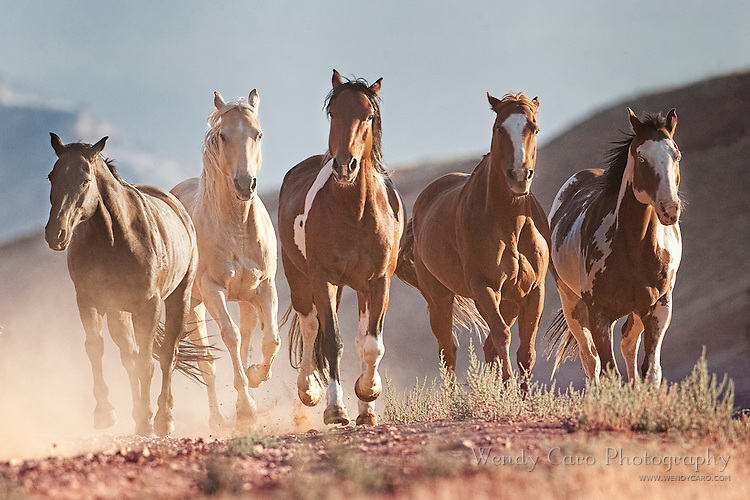

In [134]:
img = Image.open('3.jpg')

# input
img_data = preprocess(img)
img_size = np.array([img.size[1], img.size[0]], dtype=np.int32).reshape(1, 2)

# let's see what our input image looks like
img

In [82]:
%%time
# Now, let's predict using ONNX Runtime
boxes, scores, indices = session.run(None, {"input_1:01": image_data, "image_shape:01":image_size})

Wall time: 1.36 s


## Postprocessing Model Output

At this point, we've got a list of 3 arrays in our prediction with a lot of float values. Let's use the postprocessing code from the ONNX model zoo to separate them into output scores and classes. 

The model has 3 outputs:
1. boxes: (1 x `n_candidates` x 4), the coordinates of all anchor boxes
2. scores: (1 x 80 x `n_candidates`), the scores of all anchor boxes per class
3. indices: (`n_box` x 3), selected indices from the boxes tensor. The selected index format is (batch_index, class_index, box_index)

In [83]:
print('Boxes:', boxes.shape)
print('Scores:', scores.shape)
print('Indices:', indices.shape)

Boxes: (1, 10647, 4)
Scores: (1, 80, 10647)
Indices: (5, 3)


In [94]:
objects_identified = indices.shape[0]
if objects_identified > 0:
    out_boxes, out_scores, out_classes = [], [], []
    for idx_ in indices:
        out_classes.append(classes[idx_[1]])
        out_scores.append(scores[tuple(idx_)])
        idx_1 = (idx_[0], idx_[2])
        out_boxes.append(boxes[idx_1])
    print(objects_identified, "objects identified in source image.")
else:
    print("No objects identified in source image.")

5 objects identified in source image.


## Display Image with Candidate Bounding Boxes

<Figure size 432x288 with 0 Axes>

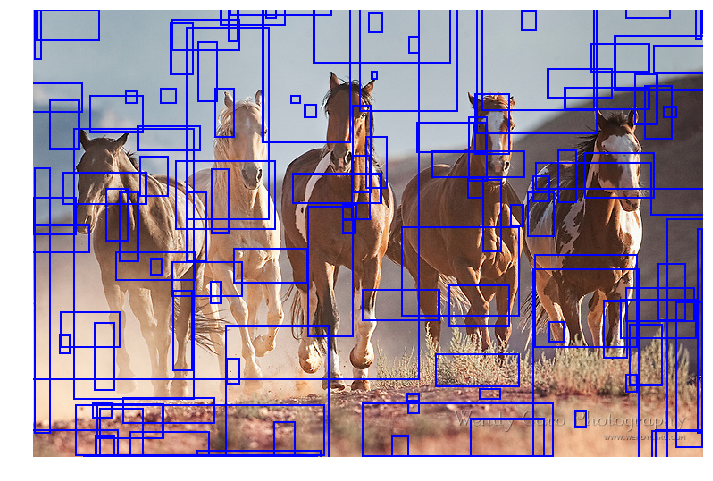

In [143]:
img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

candidate_boxes = np.random.choice(boxes.shape[1], 150, replace=False)

for c in candidate_boxes:
    y1, x1, y2, x2 = boxes[0][c]
    color = 'blue'
    box_h = (y2 - y1)
    box_w = (x2 - x1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)

plt.axis('off')
# save image
plt.savefig("horse-candidate.jpg", bbox_inches='tight', pad_inches=0.0)
plt.show()

## Display Resultant Image with Bounding Boxes and Labels

<Figure size 432x288 with 0 Axes>

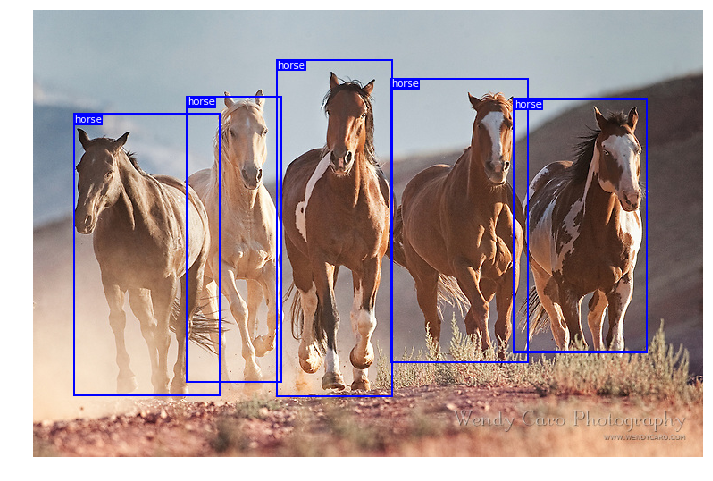

In [133]:
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

for i in range(objects_identified):
    y1, x1, y2, x2 = out_boxes[i]
    class_pred = out_classes[i]
    color = 'blue'
    box_h = (y2 - y1)
    box_w = (x2 - x1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
    plt.text(x1, y1, s=class_pred, color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})

plt.axis('off')
# save image
plt.savefig("horse-det.jpg", bbox_inches='tight', pad_inches=0.0)
plt.show()

## Object Detection for YoloV3 for Video